[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/total_variation_denoising.ipynb)
<a href="https://huggingface.co/spaces/kornia/total_variation_denoising"><img src="https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue.svg" alt="pypi version"></a>

# Denoise image using total variation


In this tutorial we are going to learn how to denoise an image using the differentiable `total_variation` loss.

In [1]:
%%capture
!pip install kornia

In [2]:
%%capture
!wget https://github.com/kornia/data/raw/main/doraemon.png

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import kornia as K

In [4]:
def imshow(input: torch.Tensor):
    out = torchvision.utils.make_grid(input, nrow=2, padding=5)
    out_np: np.ndarray = K.utils.tensor_to_image(out)
    plt.imshow(out_np)
    plt.axis('off')
    plt.show()

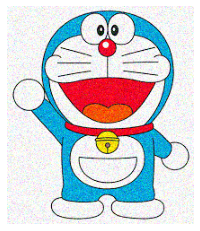

In [5]:
# read the image with OpenCV
img: np.ndarray = cv2.imread('doraemon.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
img = img + np.random.normal(loc=0.0, scale=0.1, size=img.shape)
img = np.clip(img, 0.0, 1.0)


# convert to torch tensor
noisy_image: torch.tensor = K.utils.image_to_tensor(img).squeeze()  # CxHxW
imshow(noisy_image)

We define the total variation denoising network and the optimizer

In [6]:
# define the total variation denoising network
class TVDenoise(torch.nn.Module):
    def __init__(self, noisy_image):
        super(TVDenoise, self).__init__()
        self.l2_term = torch.nn.MSELoss(reduction='mean')
        self.regularization_term = K.losses.TotalVariation()
        # create the variable which will be optimized to produce the noise free image
        self.clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)
        self.noisy_image = noisy_image

    def forward(self):
        return self.l2_term(self.clean_image, self.noisy_image) + 0.0001 * self.regularization_term(self.clean_image)

    def get_clean_image(self):
        return self.clean_image


tv_denoiser = TVDenoise(noisy_image)

# define the optimizer to optimize the 1 parameter of tv_denoiser
optimizer = torch.optim.SGD(tv_denoiser.parameters(), lr=0.1, momentum=0.9)

Run the the optimization loop

In [7]:
num_iters: int = 500
for i in range(num_iters):
    optimizer.zero_grad()
    loss = tv_denoiser().sum()
    if i % 50 == 0:
        print("Loss in iteration {} of {}: {:.3f}".format(i, num_iters, loss.item()))
    loss.backward()
    optimizer.step()

Loss in iteration 0 of 500: 3.086
Loss in iteration 50 of 500: 2.727
Loss in iteration 100 of 500: 2.362
Loss in iteration 150 of 500: 2.066
Loss in iteration 200 of 500: 1.830
Loss in iteration 250 of 500: 1.645
Loss in iteration 300 of 500: 1.500
Loss in iteration 350 of 500: 1.388
Loss in iteration 400 of 500: 1.300
Loss in iteration 450 of 500: 1.232


Visualize the noisy and resulting cleaned image

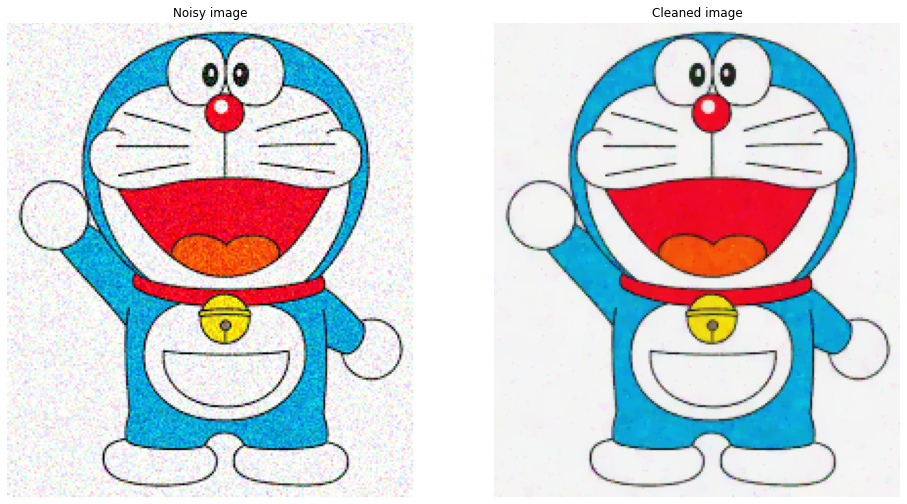

In [20]:
# convert back to numpy
img_clean: np.ndarray = K.utils.tensor_to_image(tv_denoiser.get_clean_image())

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Noisy image')
axs[0].imshow(img)

axs[1].axis('off')
axs[1].set_title('Cleaned image')
axs[1].imshow(img_clean)

plt.show()